<a href="https://colab.research.google.com/github/Syilun/face_recognition/blob/master/23_vggface_mlp512_128_8_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# 用單個模型同時執行兩個分類任務:
#   age 分成8個classes
#   gender 分成2個classes
# mlp 每個全連接層的unit個數: 512 - 128 -- 8
#                      \_ 2
# trainning: 
#   改用generator產生資料給fit_generator
#   class_weight
#   random_state
#   callback: EarlyStop, model.save


#用少量資料
FULL_DATA = 0
per_cls_trn = 500
per_cls_eval = 20 #100
#用全部資料
#FULL_DATA = 1

IMG_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 1
model_folder_path = '/content/drive/My Drive/AIoT_Project/face'
#img_folder_path = '/content/drive/My Drive/AIoT_Project/Datasets/資料集_IMDB-Wiki'
img_folder_path = '/content/drive/My Drive/AIoT_Project/Datasets/cleandataset'

time: 4.25 ms


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.44 ms


In [21]:
# to measure execution time
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.74 s


In [22]:
! nvidia-smi

Tue Sep  8 08:17:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
!pip install mtcnn

time: 2.73 s


In [24]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# import tensorflow as tf
# from tensorflow import keras
import keras
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D, BatchNormalization
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
import cv2
from glob import glob
import os
from mtcnn import MTCNN
import numpy as np

time: 11.4 ms


In [25]:
print(keras.__version__)

2.4.3
time: 1.26 ms


In [26]:
# 資料集由csv檔案讀入, 也可新增其他的csv檔案來擴充資料
# df = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_wiki.csv')
# df_under10 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_under10.csv')
# df_over70 = pd.read_csv('drive/My Drive/Tibame_AIoT_Project/Datasets/資料集_IMDB-Wiki/age_gender_imdb_over70.csv')
# df = pd.concat([df, df_under10, df_over70])

time: 2.44 ms


In [27]:
# cleandata: 清除wiki資料集原本的一些年齡標註錯誤
df = pd.read_csv(os.path.join(img_folder_path, 'cleandata.csv'))

time: 2.23 s


In [28]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]


time: 15 ms


In [29]:
# 每10歲分一類,70歲以上歸為同一類,共8類
df['age_grp'] = pd.cut(df['age'], bins=[0,10,20,30,40,50,60,70,110], right=False)
le = LabelEncoder()
le.fit(df['age_grp'].astype('str'))
df['age_cls'] = le.transform(df['age_grp'].astype('str'))
df

,full_path,gender,age,age_grp,age_cls
0,m10/26125603_1992-06-17_2011.jpg,1,10,"[10, 20)",1
1,m10/26186888_1988-04-26_2007.jpg,1,10,"[10, 20)",1
2,m10/36100953_1996-08-30_2013.jpg,1,10,"[10, 20)",1
3,m10/3613301_1923-10-10_1940.jpg,1,10,"[10, 20)",1
4,m10/36160427_1994-05-14_2014.jpg,1,10,"[10, 20)",1
...,...,...,...,...,...
34303,f0/img_3096_7.jpg_0_8531.jpg,0,5,"[0, 10)",0
34304,f0/img_3097_1.jpg_0_9338.jpg,0,5,"[0, 10)",0
34305,f0/img_3097_2.jpg_0_3851.jpg,0,5,"[0, 10)",0
34306,f0/img_3097_3.jpg_0_7887.jpg,0,5,"[0, 10)",0


time: 392 ms


In [30]:
df['age_cls'].value_counts().sort_index()

0     1097
1     2112
2    11230
3     6518
4     4618
5     4199
6     2623
7     1911
Name: age_cls, dtype: int64

time: 15 ms


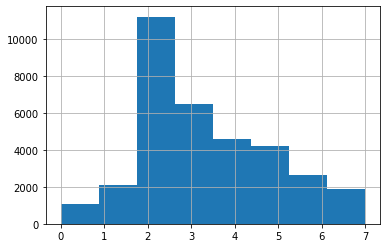

time: 286 ms


In [31]:
histogram_age = df['age_cls'].hist(bins=df['age_cls'].nunique())

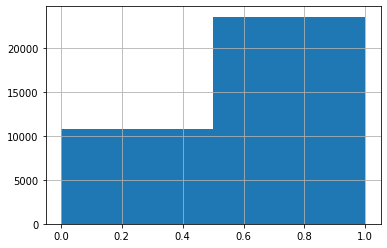

time: 204 ms


In [32]:
histogram_gender = df['gender'].hist(bins=df['gender'].nunique())

In [33]:
#先用少量資料比較不同模型:
#每個類別各取部分資料,用train_test_split來切train and test
df_f0 = df[(df['age_cls'] == 0) & (df['gender'] == 0)]
df_f1 = df[(df['age_cls'] == 1) & (df['gender'] == 0)]
df_f2 = df[(df['age_cls'] == 2) & (df['gender'] == 0)]
df_f3 = df[(df['age_cls'] == 3) & (df['gender'] == 0)]
df_f4 = df[(df['age_cls'] == 4) & (df['gender'] == 0)]
df_f5 = df[(df['age_cls'] == 5) & (df['gender'] == 0)]
df_f6 = df[(df['age_cls'] == 6) & (df['gender'] == 0)]
df_f7 = df[(df['age_cls'] == 7) & (df['gender'] == 0)]
df_m0 = df[(df['age_cls'] == 0) & (df['gender'] == 1)]
df_m1 = df[(df['age_cls'] == 1) & (df['gender'] == 1)]
df_m2 = df[(df['age_cls'] == 2) & (df['gender'] == 1)]
df_m3 = df[(df['age_cls'] == 3) & (df['gender'] == 1)]
df_m4 = df[(df['age_cls'] == 4) & (df['gender'] == 1)]
df_m5 = df[(df['age_cls'] == 5) & (df['gender'] == 1)]
df_m6 = df[(df['age_cls'] == 6) & (df['gender'] == 1)]
df_m7 = df[(df['age_cls'] == 7) & (df['gender'] == 1)]
# train and val data
if FULL_DATA == 1:
    #每個類別保留最後per_cls_eval筆資料作為evaluate用
    train_df = pd.concat([
        df_f0[:-per_cls_eval], df_f1[:-per_cls_eval], df_f2[:-per_cls_eval], df_f3[:-per_cls_eval], 
        df_f4[:-per_cls_eval], df_f5[:-per_cls_eval], df_f6[:-per_cls_eval], df_f7[:-per_cls_eval], 
        df_m0[:-per_cls_eval], df_m1[:-per_cls_eval], df_m2[:-per_cls_eval], df_m3[:-per_cls_eval], 
        df_m4[:-per_cls_eval], df_m5[:-per_cls_eval], df_m6[:-per_cls_eval], df_m7[:-per_cls_eval]         
        ])           
else:    
    #先用少量資料比較不同模型
    train_df = pd.concat([
        df_f0[:per_cls_trn], df_f1[:per_cls_trn], df_f2[:per_cls_trn], df_f3[:per_cls_trn], 
        df_f4[:per_cls_trn], df_f5[:per_cls_trn], df_f6[:per_cls_trn], df_f7[:per_cls_trn], 
        df_m0[:per_cls_trn], df_m1[:per_cls_trn], df_m2[:per_cls_trn], df_m3[:per_cls_trn], 
        df_m4[:per_cls_trn], df_m5[:per_cls_trn], df_m6[:per_cls_trn], df_m7[:per_cls_trn]         
        ])
    
# evaluate data: 每個類別保留最後per_cls_eval筆資料作為evaluate用
eval_df = pd.concat([
        df_f0[-per_cls_eval:], df_f1[-per_cls_eval:], df_f2[-per_cls_eval:], df_f3[-per_cls_eval:], 
        df_f4[-per_cls_eval:], df_f5[-per_cls_eval:], df_f6[-per_cls_eval:], df_f7[-per_cls_eval:],
        df_m0[-per_cls_eval:], df_m1[-per_cls_eval:], df_m2[-per_cls_eval:], df_m3[-per_cls_eval:], 
        df_m4[-per_cls_eval:], df_m5[-per_cls_eval:], df_m6[-per_cls_eval:], df_m7[-per_cls_eval:]         
        ])
x_eval = np.array(eval_df['full_path'])
# 先把模型的兩個輸出的答案合併
y_eval = np.array(pd.concat([eval_df['age_cls'], eval_df['gender']], axis=1))
print("train:", len(train_df), "predict:", len(eval_df))

train: 8000 predict: 320
time: 156 ms


In [34]:
# 處理答案 把它轉成one-hot (後面再做)
# y_train_category = to_categorical(df['age_cls'], num_classes=8)

# 2個輸出: age, gender
y_df = pd.concat([pd.DataFrame(train_df['age_cls']), pd.DataFrame(train_df['gender'])], axis=1)

# 切分訓練data
x_train, x_test, y_train, y_test = train_test_split(np.array(train_df['full_path']), np.array(y_df), test_size=0.2, random_state=0)

print(x_train[0], x_test[0], y_train[0], y_test[0])
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

f20/896498_1921-08-08_1950.jpg f60/2718445_1943-11-13_2010.jpg [2 0] [6 0]
(6400,) (1600,) (6400, 2) (1600, 2)
time: 11.1 ms


In [35]:
detector = MTCNN()
#feature_extractor = load_model(os.path.join(model_folder_path, 'facenet_keras.h5'))

time: 5.71 s


In [36]:
# VGGFace: https://github.com/rcmalli/keras-vggface
!pip install keras_vggface
!pip install keras_applications

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
feature_extractor = VGGFace(model='resnet50', include_top=False, 
            input_shape=(224, 224, 3), pooling='avg')

     |████████████████████████████████| 51kB 3.2MB/s 
94699520/94694792 [==============================] - 4s 0us/step
time: 13 s


In [37]:
feature_extractor.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [38]:
# 固定pre-train model的參數
for lyr in feature_extractor.layers:
    lyr.trainable = False

# BN
x = BatchNormalization()(feature_extractor.output)    
    
# MLP    
# x = Flatten()(x)

#x = Dense(units=2048, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
age = Dense(units=8, activation='softmax', name='age')(x)
gender = Dense(units=2, activation='softmax', name='gender')(x)
# 2個輸出: age, gender
age_gender_model = Model(inputs=feature_extractor.input, outputs=[age, gender])   
age_gender_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
_______________________________________________________________________________________

In [39]:
age_gender_model.compile(loss=["categorical_crossentropy","categorical_crossentropy"], 
                  optimizer='adam', metrics=[{'age':'accuracy'},{'gender':'accuracy'}]) # 2個輸出: age, gender
#age_gender_model.load_weights(os.path.join(model_folder_path,'23_vggface_weight_mlp512-128-8_2_epoch.h5'))

time: 27.6 ms


In [40]:
# 資料預處理 for facenet?
# Standardization
def preprocess(imgs): 
    for i in range(imgs.shape[0]):
        # standardization
        img = imgs[i]
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        imgs[i] = img
    return imgs
# Normalization
def normalize(img):
    return img / 255.

# -1 <= x <= 1
def preprocess_1(imgs):
    x = np.array(imgs, dtype = float)
    x /= 127.5
    x -= 1.
    return x    

time: 8.71 ms


In [41]:
# detect face
def detect_faces(img):
    face_imgs = []
    results = detector.detect_faces(img)
    # extract the bounding box from the first face
    # print('# of faces: ', len(results))
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[y1:y2, x1:x2] # crop face
        face_imgs.append(patch)
    return face_imgs

time: 6.16 ms


In [42]:
def data_generator(data_paths, y_data, batch_size=BATCH_SIZE, eval=0):
    '''data generator for fit_generator'''
    n = len(data_paths)
    i = 0
    data_paths = data_paths
    
    # eval=0: 產生infinite train and validate 資料
    # eval=1: 產生finite evaluate 資料
    while i < n: 
        x_ori, x_norm, y_age, y_gender = [], [], [], []
        i_batch = i
        for b in range(batch_size):
            path = data_paths[i]
            print("n:", n, "idx:", i, "cls:", y_data[i], path)
        
            # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理 
            try:          
                img = cv2.imread(os.path.join(img_folder_path,path))[:,:,::-1]
            except:
                print('imread failed')
                if eval == 0:
                    i = (i+1) % n
                else:    
                    i = (i+1)
                continue                   
            
            # plt.imshow(img)
            # plt.show()
            faces = detect_faces(img)
            if len(faces) == 0 or faces[0].shape[0] == 0 or faces[0].shape[1] == 0:
                print('No face')
                if eval == 0:
                    i = (i+1) % n
                else:    
                    i = (i+1)
                continue   
            # print(faces[0].shape)    
            img_crop = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
            # plt.imshow(faces[0])
            # plt.show()

            # 使用借來的模型的預處理方式來作預處理
            img_pre = preprocess_input(np.array(img_crop,dtype=float))

            # 把原圖留下來
            x_ori.append(img)
            x_norm.append(img_pre)
            y_age.append(y_data[i][0])
            y_gender.append(y_data[i][1])
            
            if eval == 0:
                i = (i+1) % n
            else:    
                i = (i+1)

        # print("len(image_data)",len(x_ori))
        # plt.figure(figsize=(10, 40))
        # for j,m in enumerate(x_ori):
        #     plt.subplot(1, BATCH_SIZE, (j%BATCH_SIZE)+1)
        #     plt.title("idx:{} y_data:{}".format(i_batch+j, y_data[i_batch+j]))
        #     plt.axis("off")
        #     plt.imshow(m)
        # plt.show() 

        
        # 2個輸出: age, gender  
        # print(type(y_age), len(y_age), y_age[:8])
        # print(type(y_gender), len(y_gender), y_gender[:8])
        y_age_category = to_categorical(y_age, num_classes=8) 
        y_gender_category = to_categorical(y_gender, num_classes=2) 
        # print(y_age_category)
        # print(y_gender_category)
        x_input = {'input_4':np.array(x_norm)}
        y_category = {'age':np.array(y_age_category), 'gender':np.array(y_gender_category)}
        # print(type(np.array(x_norm)), np.array(x_norm).shape)
        # print(type(y_category), np.array(y_age_category), np.array(y_gender_category))
        yield x_input, y_category

time: 80.1 ms


In [43]:
# 用generator產生資料
generator_train = data_generator(x_train, y_train, batch_size=BATCH_SIZE)
generator_test = data_generator(x_test, y_test, batch_size=BATCH_SIZE)
type(generator_train)

generator

time: 4.95 ms


In [44]:
if FULL_DATA == 1:
    age_weights = {0:12., 1:5., 2:1., 3:2., 4:3., 5:4., 6:6., 7:3.}
else:    
    # for temp
    age_weights = {0:1., 1:1., 2:1., 3:1., 4:1., 5:1., 6:1., 7:1.}
    

time: 4.27 ms


In [45]:
# fit_generator
checkpoint = ModelCheckpoint(os.path.join(model_folder_path,"23_vggface_weight_mlp512-128-8_2_epoch.h5"), 
                save_best_only=False, save_weights_only=True)   #Defaults: save_freq='epoch', save_weights_only=False
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
#logs = age_gender_model.fit_generator(
logs = age_gender_model.fit(    
        generator_train,
        epochs=EPOCHS,
        use_multiprocessing=False, #for deadlock issue while 2nd epoch running
        steps_per_epoch=len(x_train)//BATCH_SIZE,
        validation_data=generator_test,
        validation_steps=len(x_test)//BATCH_SIZE,
        #class_weight=age_weights, #class_weight` is only supported for Models with a single output.
        #validation_split=0.1,   #fit_generator() got an unexpected keyword argument 'validation_split'
        callbacks=[checkpoint, earlystop] 
        )

串流輸出內容已截斷至最後 5000 行。
n: 6400 idx: 3044 cls: [3 0] f30/1850686_1949-04-07_1982.jpg
 761/1600 [=============>................] - ETA: 48:02 - loss: 1.8450 - age_loss: 1.5002 - gender_loss: 0.3448 - age_accuracy: 0.4220 - gender_accuracy: 0.8556n: 6400 idx: 3045 cls: [0 0] f0/img_3771_5.jpg
n: 6400 idx: 3046 cls: [3 0] f30/12635050_1981-10-17_2013.jpg
n: 6400 idx: 3047 cls: [5 0] f50/659032_1961-10-16_2012.jpg
n: 6400 idx: 3048 cls: [2 0] f20/33855934_1984-03-10_2011.jpg
 762/1600 [=============>................] - ETA: 47:59 - loss: 1.8454 - age_loss: 1.5007 - gender_loss: 0.3447 - age_accuracy: 0.4218 - gender_accuracy: 0.8558n: 6400 idx: 3049 cls: [7 0] f70/299078_1934-03-25_2011.jpg_0_1345.jpg
n: 6400 idx: 3050 cls: [0 1] m0/img_3068_6.jpg
n: 6400 idx: 3051 cls: [3 0] f30/46525817_1980-05-15_2013.jpg
n: 6400 idx: 3052 cls: [0 0] f0/3259791_1940-07-04_1946.jpg_0_894.jpg
 763/1600 [=============>................] - ETA: 47:55 - loss: 1.8463 - age_loss: 1.4998 - gender_loss: 0.3465 - age

In [62]:
age_gender_model.save_weights(os.path.join(model_folder_path,'23_vggface_weight_mlp512-128-8_2.h5'))

time: 900 ms


In [63]:
history = logs.history
history

{'age_accuracy': [0.4419993758201599],
 'age_loss': [1.3881350755691528],
 'gender_accuracy': [0.8778685927391052],
 'gender_loss': [0.3027587831020355],
 'loss': [1.6908948421478271],
 'val_age_accuracy': [0.5406427383422852],
 'val_age_loss': [1.0746912956237793],
 'val_gender_accuracy': [0.9231253862380981],
 'val_gender_loss': [0.19615329802036285],
 'val_loss': [1.27084481716156]}

time: 9.19 ms


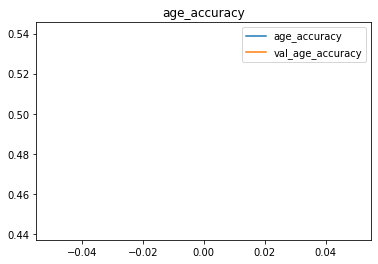

time: 211 ms


In [64]:
plt.plot(history['age_accuracy'])
plt.plot(history['val_age_accuracy'])
plt.legend(['age_accuracy', 'val_age_accuracy'])
plt.title('age_accuracy')
plt.show()

Text(0.5, 1.0, 'gender_accuracy')

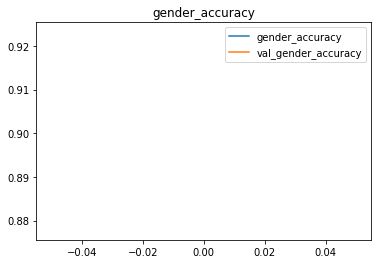

time: 239 ms


In [65]:
plt.plot(history['gender_accuracy'])
plt.plot(history['val_gender_accuracy'])
plt.legend(['gender_accuracy', 'val_gender_accuracy'])
plt.title('gender_accuracy')

Text(0.5, 1.0, 'loss')

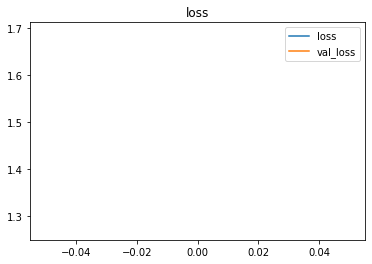

time: 254 ms


In [66]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [67]:
# cur_train_idx = 0
# cur_test_idx = 0
# def get_data(x, y, batch=20, IMG_SIZE=160, test=1):
#     # 要注意 numpy 中的 randint 的上限是不包含的 和一般的randint不同
#     # numpy array 的索引可以是個 list, 即可同時取出不只一個元素
#     global cur_train_idx, cur_test_idx
#     print("cur train/test idx:", cur_train_idx, cur_test_idx)    
#     if test == 0:
#         #idx = np.random.randint(0, len(x), batch)
#         idx = list(range(cur_train_idx, cur_train_idx+batch, 1))
#         cur_train_idx = (cur_train_idx + batch) % len(x)
#     else:
#         #idx = np.random.randint(0, len(x), batch)
#         idx = list(range(cur_test_idx, cur_test_idx+batch, 1))
#         cur_test_idx += batch

#     #print("idx:", idx, x[idx], y[idx])
#     x_idx = x[idx]
#     y_idx = y[idx]
#     x_ori, x_norm, y_ori = [], [], y_idx
#     for i,p in enumerate(x_idx):
#         print(p)
#         # 讀取圖片,切下臉的部分,並使用借來的模型的預處理方式來作預處理
#         img = np.array(cv2.imread(os.path.join(img_folder_path,p))[:,:,::-1])
#         # plt.imshow(img)
#         # plt.show()
#         faces = detect_faces(img)
#         if len(faces) == 0 or faces[0].shape[0] == 0:
#             print('No face')
#             continue   
#         img = cv2.resize(faces[0], (IMG_SIZE, IMG_SIZE))
#         # plt.imshow(faces[0])
#         # plt.show()

#         # 使用借來的模型的預處理方式來作預處理
#         img_pre = preprocess_input(np.array(img,dtype=float))
#         #img_pre = preprocess_1(img)
#         #img_pre = normalize(img)
        
#         # 把原圖留下來
#         x_ori.append(img)
#         x_norm.append(img_pre)
#     return np.array(x_ori), np.array(x_norm), np.array(y_ori)

# # 取出要用來預測的資料
# x_ori_batch, x_batch, y_batch = get_data(x_eval, y_eval, batch=100, IMG_SIZE=224) 
# print(y_batch)   

time: 5.2 ms


In [52]:
# evaluate
#
# 從保留作為evaluate用的資料,用generator產生資料 to predict
generator_predict = data_generator(x_eval, y_eval, batch_size=BATCH_SIZE, eval=1)

# 把generator_predict返回的物件轉成list
eval_data = list(generator_predict)
# elements of the list are tuples, elements of the tuples are dicts
# [(dict of x, dict of y), (dict of x, dict of y), .....]

# 取出圖片資料與正確答案
x_eval_data, y_true_age, y_true_gender = [], [], []
for x_dict,y_dict in eval_data:
    # print("x_eval_data:", len(list(x_dict['input_4'])))
    x_eval_data = x_eval_data + list(x_dict['input_4'])
    # print("y_true_age:", y_dict['age'].argmax(axis=-1))
    # print("y_true_gender:", y_dict['gender'].argmax(axis=-1))    
    y_true_age = y_true_age + (list(y_dict['age'].argmax(axis=-1)))
    y_true_gender = y_true_gender + (list(y_dict['gender'].argmax(axis=-1)))

# print("-------------------------")
print("x_eval_data:", type(x_eval_data), "np.array:", np.array(x_eval_data).shape)
print("y_true_age:", y_true_age)
print("y_true_gender:", y_true_gender)

n: 320 idx: 0 cls: [0 0] f0/img_3084_11.jpg_0_8772.jpg
No face
n: 320 idx: 1 cls: [0 0] f0/img_3084_12.jpg_0_1373.jpg
n: 320 idx: 2 cls: [0 0] f0/img_3084_13.jpg_0_4722.jpg
n: 320 idx: 3 cls: [0 0] f0/img_3084_14.jpg_0_5501.jpg
No face
n: 320 idx: 4 cls: [0 0] f0/img_3085_2.jpg_0_6163.jpg
n: 320 idx: 5 cls: [0 0] f0/img_3086_5.jpg_0_4553.jpg
n: 320 idx: 6 cls: [0 0] f0/img_3087_3.jpg_0_8221.jpg
n: 320 idx: 7 cls: [0 0] f0/img_3087_4.jpg_0_3611.jpg
n: 320 idx: 8 cls: [0 0] f0/img_3095_4.jpg_0_8506.jpg
n: 320 idx: 9 cls: [0 0] f0/img_3095_6.jpg_0_2285.jpg
n: 320 idx: 10 cls: [0 0] f0/img_3095_7.jpg_0_984.jpg
n: 320 idx: 11 cls: [0 0] f0/img_3096_2.jpg_0_1028.jpg
n: 320 idx: 12 cls: [0 0] f0/img_3096_3.jpg_0_3174.jpg
n: 320 idx: 13 cls: [0 0] f0/img_3096_4.jpg_0_3756.jpg
n: 320 idx: 14 cls: [0 0] f0/img_3096_5.jpg_0_2926.jpg
n: 320 idx: 15 cls: [0 0] f0/img_3096_7.jpg_0_8531.jpg
n: 320 idx: 16 cls: [0 0] f0/img_3097_1.jpg_0_9338.jpg
n: 320 idx: 17 cls: [0 0] f0/img_3097_2.jpg_0_3851.jpg
n

In [53]:
# predict
pre = age_gender_model.predict(np.array(x_eval_data), steps=len(x_eval)//BATCH_SIZE)
#pre[0] is predicted probabilities for age
#pre[1] is predicted probabilities for gender
pred_age = pre[0].argmax(axis=-1)
pred_gender = pre[1].argmax(axis=-1)
print("predict age:",pred_age)
print("predict gender:",pred_gender)

predict age: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 2 1 1 1 1 1 2 2 0 1 5 2 1 2 1 1
 1 4 3 1 5 1 1 3 4 4 2 2 4 1 1 4 2 1 2 2 2 3 4 2 4 1 4 1 5 4 3 4 3 1 4 1 4
 4 1 1 4 4 4 4 6 5 5 4 4 3 4 5 0 5 4 4 7 5 4 5 4 6 5 5 4 4 6 5 4 4 5 6 4 4
 6 6 5 4 7 5 5 6 6 5 5 6 5 5 6 5 7 7 6 0 5 5 5 6 0 5 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 2 1 1 0 1 1
 1 2 2 1 1 1 1 1 2 1 4 1 2 2 1 2 1 1 1 1 2 1 1 1 2 2 1 2 2 2 4 4 2 2 4 2 4
 4 4 4 4 2 2 4 1 2 1 4 3 2 4 3 5 5 4 4 4 4 4 4 4 3 1 4 4 4 4 4 7 4 5 5 4 4
 4 4 4 5 4 4 5 4 7 5 4 4 7 4 4 4 5 5 4 7 7 5 4 5 7 7 7 7 7 7 7 7 5 7 7 7 7
 7 6 7 7 7 5 7 4 7 7 7 7 7 7 7 7 7 7 5]
predict gender: [0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 

In [54]:
len(pred_age), len(pred_gender)

(315, 315)

time: 5.67 ms


In [55]:
from sklearn.metrics import classification_report
print(np.array(y_true_age).shape, np.array(pred_age).shape, np.array(y_true_gender).shape, np.array(pred_gender).shape)
age_target_names = [str(i) for i in range(8)]
gender_target_names = [str(i) for i in range(2)]
print(classification_report(np.array(y_true_age), np.array(pred_age), target_names=age_target_names))
print(classification_report(np.array(y_true_gender), np.array(pred_gender), target_names=gender_target_names))

(315,) (315,) (315,) (315,)
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        35
           1       0.51      0.65      0.57        40
           2       0.44      0.38      0.41        40
           3       0.44      0.10      0.16        40
           4       0.33      0.60      0.43        40
           5       0.31      0.30      0.30        40
           6       0.50      0.17      0.26        40
           7       0.64      0.90      0.75        40

    accuracy                           0.50       315
   macro avg       0.51      0.51      0.48       315
weighted avg       0.50      0.50      0.47       315

              precision    recall  f1-score   support

           0       0.94      0.85      0.90       158
           1       0.87      0.95      0.91       157

    accuracy                           0.90       315
   macro avg       0.91      0.90      0.90       315
weighted avg       0.91      0.90      0.90      

In [56]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_true_age, pred_age),
            index=["{}(真實)".format(i) for i in range(8)],
            columns=["{}(預測)".format(i) for i in range(8)] 
            )

,0(預測),1(預測),2(預測),3(預測),4(預測),5(預測),6(預測),7(預測)
0(真實),35,0,0,0,0,0,0,0
1(真實),2,26,11,0,0,1,0,0
2(真實),0,16,15,2,6,1,0,0
3(真實),0,8,8,4,19,1,0,0
4(真實),1,1,0,3,24,8,1,2
5(真實),0,0,0,0,20,12,5,3
6(真實),2,0,0,0,2,14,7,15
7(真實),0,0,0,0,1,2,1,36


time: 26.2 ms


In [57]:
pd.DataFrame(confusion_matrix(y_true_gender, pred_gender),
            index=["{}(真實)".format(i) for i in range(2)],
            columns=["{}(預測)".format(i) for i in range(2)] 
            )

,0(預測),1(預測)
0(真實),135,23
1(真實),8,149


time: 18 ms


In [58]:
def euclidean_distance(x, y):
    sum_square = np.sum(np.square(x - y), keepdims=True)
    return np.sqrt(sum_square)

time: 2.21 ms


In [59]:
def predict_age(img):
    img_size = 100
    img = normalize(img)
    img = cv2.resize(img, (img_size, img_size))
    model_input = np.zeros((1, img_size, img_size, 3))
    model_input[0] = img
    ages = age_model.predict(model_input)
    print('age: ', ages.argmax(axis=-1))
    return 

# def predict_gender(img):
#     img_size = 100
#     img = normalize(img)
#     img = cv2.resize(img, (img_size, img_size))
#     model_input = np.zeros((1, img_size, img_size, 3))
#     model_input[0] = img
#     genders = model_gender.predict(model_input)
#     gender = genders[0]
#     if gender > 0.5:
#         print('Male')
#     else:
#         print('Female')
#     return    

time: 16.7 ms


In [60]:
folder_path = '/content/drive/My Drive/勞動部/week10/face_detection'
def face_id(filename, IMG_SIZE=160):
    raw_img = cv2.imread(os.path.join(folder_path, filename))[:,:,::-1]
    faces = detect_faces(raw_img)
    if len(faces) == 0:
        print('No face')
        return
    else:
        # get face embeddings
        face = faces[0]
        # More predictions
        predict_age(face)
        # predict_emotion(face)
        # predict_gender(face)
        # # ID
        # face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
        # model_input = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
        # model_input[0] = face
        # model_input = preprocess(model_input)
        # query_embeddings = feature_extractor.predict(model_input)
        # query_embedding = query_embeddings[0]
        
        # # compute distance
        # distances = np.zeros((len(embeddings)))
        # for i, embed in enumerate(embeddings):
        #     distance = euclidean_distance(embed, query_embedding)
        #     distances[i] = distance

        # # find min distance    
        # idx_min = np.argmin(distances)
        # distance, name = distances[idx_min], names[idx_min]
        # print('name: ', name, ' distance: ',distance)

time: 23 ms


In [61]:
# path = 'face3.jpg'
# face_id(path)
# plt.imshow(cv2.imread(os.path.join(folder_path, path))[:,:,::-1])

time: 1.4 ms
